In [1]:
import scvi
import scanpy as sc
import anndata
import matplotlib.pyplot as plt
from matplotlib.pyplot import rc_context
sc.set_figure_params(figsize=(4, 4))
import pandas as pd
import numpy as np

Global seed set to 0


In [2]:
all_matrices = sc.read_h5ad('raw_matrix.h5ad')

In [3]:
sc.pp.filter_cells(all_matrices, min_genes=200)
sc.pp.filter_genes(all_matrices, min_cells=3)

In [4]:
all_matrices.var['mt'] = all_matrices.var_names.str.startswith('MT-')
sc.pp.calculate_qc_metrics(all_matrices, 
                           qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

In [5]:
all_matrices.var['ribo'] = all_matrices.var_names.str.startswith(("RPS","RPL"))
sc.pp.calculate_qc_metrics(all_matrices, qc_vars=['ribo'], percent_top=None, 
                           log1p=False, inplace=True)

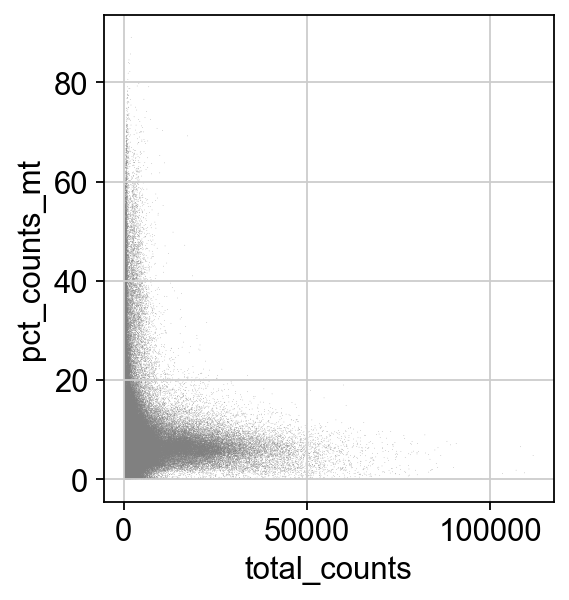

In [6]:
sc.pl.scatter(all_matrices, x='total_counts', y='pct_counts_mt')

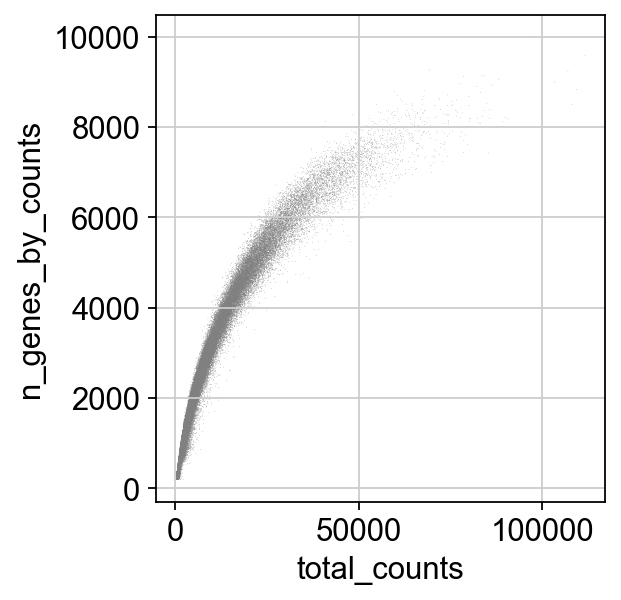

In [7]:
sc.pl.scatter(all_matrices, x='total_counts', y='n_genes_by_counts')

In [8]:
all_matrices.obs['drug'] = None

In [9]:
all_matrices.obs['match_bc'] = all_matrices.obs['bc'].astype(str) + '_' + \
                                        all_matrices.obs['sample'].astype(str)

In [11]:
mapping = pd.read_csv('HTOs.csv')
mapping.columns = ['bc', 'drug']
bc_dict = dict(zip(mapping['bc'], mapping['drug']))

In [ ]:
samples = ['L009', 'L010', 'L011', 'L012', 'L013', 'L014']
names = ['L003', 'L004', 'L005', 'L006', 'L007', 'L008']

for (sample, name) in zip(samples, names):
    for lane in ['L001', 'L002']:
        out = pd.read_csv('./pymulti/{}_{}_calls.tsv'.format(sample, lane), sep='\t')[['cell', 'call']]
        for i in out.index:
            bc = out['cell'][i] + '-1_' + name
            call = out['call'][i]
            all_matrices.obs.loc[all_matrices.obs['match_bc'] == bc, 'drug'] = bc_dict[call]

In [ ]:
all_matrices = all_matrices[all_matrices.obs.n_genes_by_counts < 7500, :]
all_matrices = all_matrices[all_matrices.obs.pct_counts_mt < 30, :]

In [ ]:
all_matrices.layers['counts'] = all_matrices.X.copy()

In [ ]:
sc.pp.normalize_total(all_matrices)

In [ ]:
all_matrices.layers['logged'] = all_matrices.X.copy()
sc.pp.log1p(all_matrices, layer='logged')

In [ ]:
sc.pp.neighbors(all_matrices, use_rep='X')
sc.tl.umap(all_matrices, min_dist=0.3) 

In [ ]:
sc.tl.leiden(all_matrices, resolution=0.3)

In [ ]:
all_matrices.write('final_processed_matrix.h5ad')